In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
tqdm.pandas()

RANDOM_STATE = 1

def _wrp(row, model):
    s = simi.pairwise_cosine_similarity(simi.model_embeddings(model, [row["a"], row["p"], row["n"]]))[0]
    if s[1] > s[0]:
        return (*s, 0)
    return (*s, 1)

# SentenceTransformers cosine-similarity scoring for (m)class
def st_similarity_scoring(df, model, append=False, name="cos-sim"):
    ap_scores, an_scores, labels = zip(*df.progress_apply(lambda r: _wrp(r, model), axis=1))
    ap_scores = pd.Series(ap_scores, index=df.index, name=name+" a-p")
    an_scores = pd.Series(an_scores, index=df.index, name=name+" a-n")
    labels = pd.Series(labels, index=df.index, name="label")
    if append:
        df = df.merge(ap_scores.to_frame(), left_index=True, right_index=True)
        df = df.merge(an_scores.to_frame(), left_index=True, right_index=True)
        df = df.merge(labels.to_frame(), left_index=True, right_index=True)
        return df
    return ap_scores, an_scores, labels

2024-01-14 20:57:23.909624: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load and select test data

In [2]:
df = pd.read_csv("anchor-arxiv-dataset.csv", index_col=0)
df.sample(5)

,title,abstract,categories,doi,a,p,n
51921,Quantum tomography and nonlocality,We present a tomographic approach to the stu...,"('quant-ph', 'math-ph', 'math.MP')",NaN,Bell inequalities for tomograms belonging to a...,"Then, possible violations of these inequalitie...",We study the following sandpile model on \Lambda.
6363,Quiver diagonalization and open BPS states,We show that motivic Donaldson-Thomas invari...,"('hep-th', 'math-ph', 'math.MP', 'math.QA', 'm...",NaN,Consequences of this statement include a gener...,"In particular, this means that the already kno...",The generalized clustering conditions are usef...
17036,On a theorem of M. Cartwright in higher dimens...,We consider harmonic functions in the unit b...,"('math.CA', 'math.AP')",10.1112/jlms/jdv060,We consider harmonic functions in the unit ba...,Our main result gives some conditions on $w$ t...,Two equations are on the boundary and two on t...
30122,Virtual harmony,This article serves a few purposes. First of...,"('math.SG', 'math.AT', 'math.DG')",NaN,"First of all, it reviews polyfold--Kuranishi c...",It is also a written-up and expanded version o...,with non-degenerate singularities has a singul...
75951,Stability of homogeneous bundles on P^3,We study the stability of some homogeneous b...,"('math.AG', 'math.RT')",10.1007/s10711-011-9617-9,In particular we show that homogeneous bundles...,We study the stability of some homogeneous bu...,"As an application, we introduce a new type of ..."


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 73760 eval: 9221 test: 9221


## Model definitions

In [4]:
# combine models into dict
eval_models = {
    'SBERT+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./sbert+retrain_anchor_arxiv_class_zbmath'),
    'SBERT+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./sbert+retrain_class_zbmath_anchor_arxiv'),
    'SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./sbert+retrain_class_arxiv_class_zbmath_anchor_arxiv'),
    'SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM': SentenceTransformer('./sbert+retrain_anchor_arxiv_class_arxiv_class_zbmath'),
    'SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./sbert+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
    
    'SPECTER2+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./specter2+mp+retrain_anchor_arxiv_class_zbmath'),
    'SPECTER2+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./specter2+mp+retrain_class_zbmath_anchor_arxiv'),
    'SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./specter2+mp+retrain_class_arxiv_class_zbmath_anchor_arxiv'),
    'SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM': SentenceTransformer('./specter2+mp+retrain_anchor_arxiv_class_arxiv_class_zbmath'),
    'SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./specter2+mp+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
    
    'BERT+MLM+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_anchor_arxiv_class_zbmath'),
    'BERT+MLM+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath_anchor_arxiv'),
    'BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv_class_zbmath_anchor_arxiv'),
    'BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_arxiv_anchor_class_arxiv_class_zbmath'),
    'BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM': SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
}

## Spearman-Pearson-rank-coefficient for test data

In [5]:
eval_examples = X_test.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["a"], r["p"], r["n"]]), axis=1)
evaluator = evaluation.TripletEvaluator.from_input_examples(eval_examples, batch_size=64, main_distance_function=0, show_progress_bar=True)

In [6]:
%%time
eval_results = {}

with tqdm(total=len(eval_models), desc="Models") as pb:
    for n,m in eval_models.items():
        eval_results[n] = [m.evaluate(evaluator)]
        pb.update()

eval_result_df = pd.DataFrame(eval_results)

Models:   0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

CPU times: user 46min 20s, sys: 1min 52s, total: 48min 12s
Wall time: 13min 26s


In [7]:
pd.set_option('display.max_columns', 40)

In [8]:
eval_result_df

,SBERT+ANCH-ARX+CLASS-ZBM,SBERT+CLASS-ZBM+ANCH-ARX,SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX,SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM,SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM,SPECTER2+ANCH-ARX+CLASS-ZBM,SPECTER2+CLASS-ZBM+ANCH-ARX,SPECTER2+CLASS-ARX+CLASS-ZBM+ANCH-ARX,SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM,SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM,BERT+MLM+ANCH-ARX+CLASS-ZBM,BERT+MLM+CLASS-ZBM+ANCH-ARX,BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX,BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM,BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM
0,0.691682,0.689079,0.68626,0.677584,0.682464,0.898709,0.899252,0.891335,0.889058,0.889491,0.891118,0.889058,0.891986,0.893179,0.895673


## Cosine-Similarity for test data

In [9]:
X_test_score = X_test.copy()

In [10]:
%%time
with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        ap_scores, an_scores, labels = st_similarity_scoring(X_test, m)
        X_test_score["cos-sim (a--p {})".format(n)] = ap_scores
        X_test_score["cos-sim (a--n {})".format(n)] = an_scores
        X_test_score["label ({})".format(n)] = labels
        pb.update()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

CPU times: user 2h 9min 9s, sys: 1min 29s, total: 2h 10min 38s
Wall time: 24min 45s


In [11]:
X_test_score.describe()

,cos-sim (a--p SBERT+ANCH-ARX+CLASS-ZBM),cos-sim (a--n SBERT+ANCH-ARX+CLASS-ZBM),label (SBERT+ANCH-ARX+CLASS-ZBM),cos-sim (a--p SBERT+CLASS-ZBM+ANCH-ARX),cos-sim (a--n SBERT+CLASS-ZBM+ANCH-ARX),label (SBERT+CLASS-ZBM+ANCH-ARX),cos-sim (a--p SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (a--n SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),label (SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (a--p SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (a--n SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),label (SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (a--p SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (a--n SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM),label (SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (a--p SPECTER2+ANCH-ARX+CLASS-ZBM),cos-sim (a--n SPECTER2+ANCH-ARX+CLASS-ZBM),label (SPECTER2+ANCH-ARX+CLASS-ZBM),cos-sim (a--p SPECTER2+CLASS-ZBM+ANCH-ARX),cos-sim (a--n SPECTER2+CLASS-ZBM+ANCH-ARX),...,cos-sim (a--n SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM),label (SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (a--p SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (a--n SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),label (SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (a--p BERT+MLM+ANCH-ARX+CLASS-ZBM),cos-sim (a--n BERT+MLM+ANCH-ARX+CLASS-ZBM),label (BERT+MLM+ANCH-ARX+CLASS-ZBM),cos-sim (a--p BERT+MLM+CLASS-ZBM+ANCH-ARX),cos-sim (a--n BERT+MLM+CLASS-ZBM+ANCH-ARX),label (BERT+MLM+CLASS-ZBM+ANCH-ARX),cos-sim (a--p BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (a--n BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),label (BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (a--p BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (a--n BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),label (BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (a--p BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (a--n BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM),label (BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM)
count,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,...,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000
mean,0.474821,0.046400,0.691682,0.472876,0.043505,0.688754,0.463178,0.051530,0.686260,0.454265,0.053721,0.677692,0.461133,0.053344,0.679210,0.526200,0.139603,0.896107,0.521195,0.136642,...,0.147706,0.884286,0.522332,0.151331,0.887431,0.571624,0.161914,0.888624,0.569604,0.157884,0.887973,0.567685,0.154971,0.887756,0.565067,0.153623,0.890684,0.567294,0.151729,0.893721
std,0.743712,0.799828,0.461824,0.755773,0.814754,0.463028,0.771148,0.831043,0.464037,0.764084,0.818335,0.467385,0.756775,0.815837,0.466805,0.217956,0.213371,0.305139,0.221452,0.213705,...,0.215808,0.319899,0.217325,0.215242,0.316083,0.228602,0.245443,0.314614,0.228665,0.247059,0.315417,0.230062,0.249022,0.315683,0.230868,0.246482,0.312052,0.231321,0.250503,0.308211
min,-0.998946,-0.999199,0.000000,-0.998848,-0.999236,0.000000,-0.998743,-0.998791,0.000000,-0.999176,-0.999289,0.000000,-0.999097,-0.999134,0.000000,-0.402207,-0.505215,0.000000,-0.403596,-0.504444,...,-0.481523,0.000000,-0.334581,-0.489606,0.000000,-0.507961,-0.508797,0.000000,-0.462955,-0.609638,0.000000,-0.561349,-0.586107,0.000000,-0.472871,-0.549655,0.000000,-0.479306,-0.590263,0.000000
25%,-0.195782,-0.875267,0.000000,-0.260807,-0.933074,0.000000,-0.260698,-0.968570,0.000000,-0.241614,-0.959735,0.000000,-0.122678,-0.965371,0.000000,0.383904,-0.012923,1.000000,0.378567,-0.017301,...,-0.007293,1.000000,0.378105,-0.000358,1.000000,0.432941,-0.018980,1.000000,0.430042,-0.020438,1.000000,0.426409,-0.028814,1.000000,0.425795,-0.027784,1.000000,0.425833,-0.030264,1.000000
50%,0.996482,0.279028,1.000000,0.997294,0.299510,1.000000,0.996963,0.356708,1.000000,0.997702,0.235407,1.000000,0.997908,0.272380,1.000000,0.553318,0.131025,1.000000,0.5468

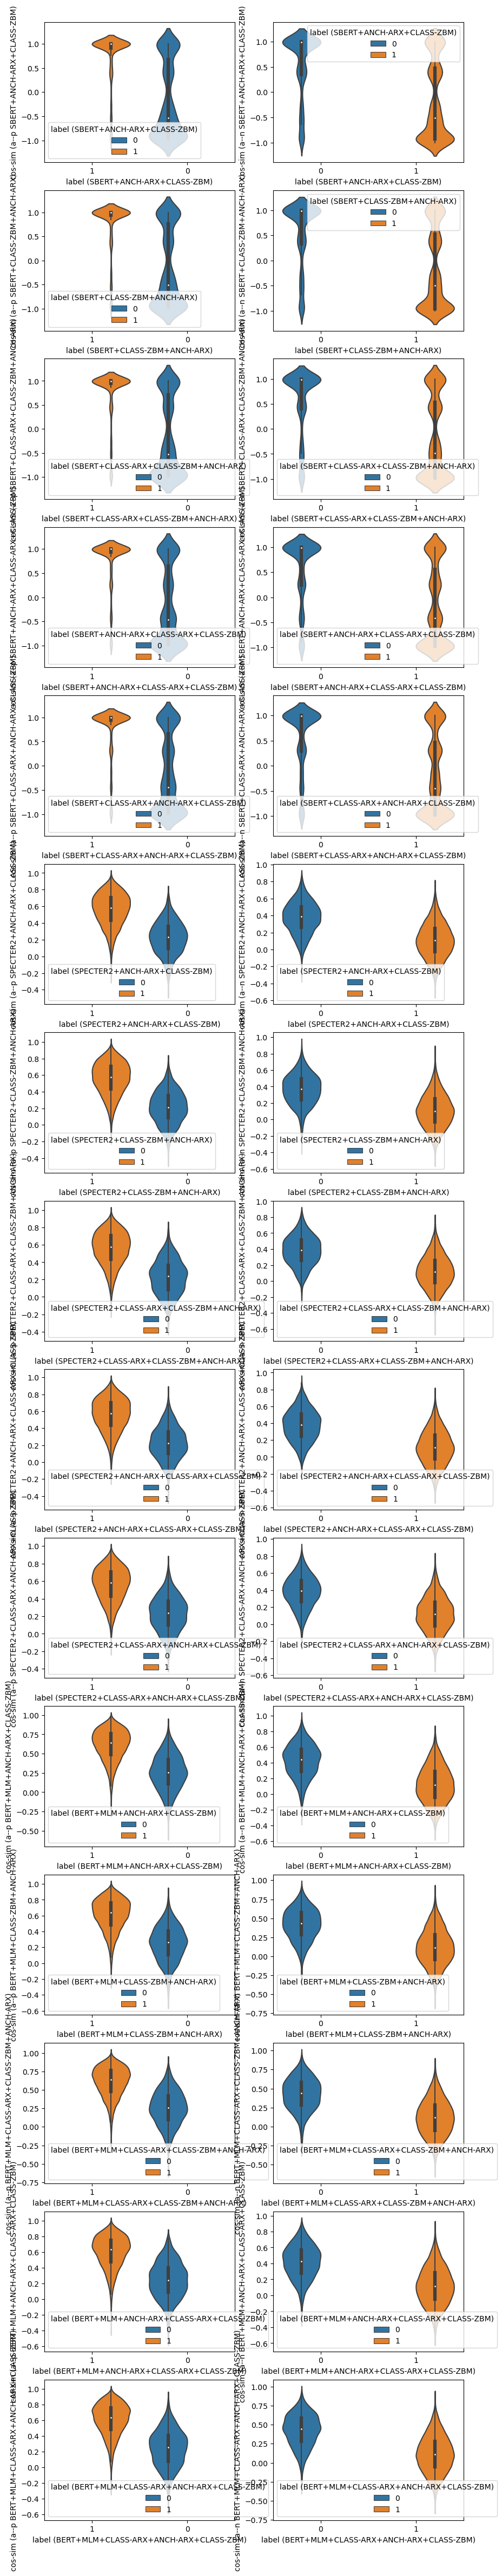

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 2, figsize=(10, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.violinplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--p {})".format(n), hue="label ({})".format(n), order=[1, 0], scale="count", scale_hue=True, ax=axs[i][0])
    sns.violinplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--n {})".format(n), hue="label ({})".format(n), scale="count", scale_hue=True, ax=axs[i][1])

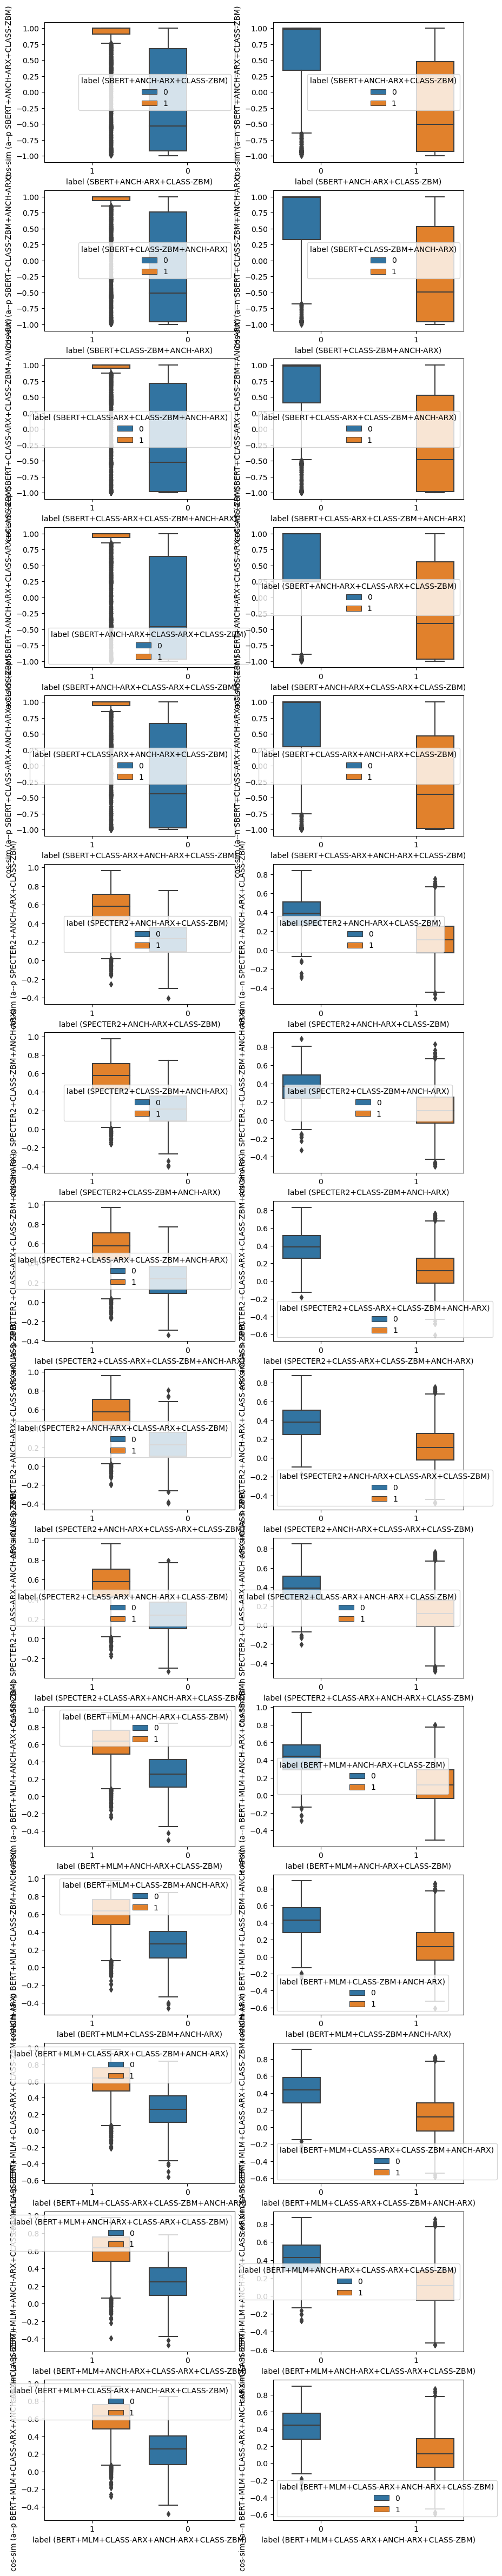

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 2, figsize=(10, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.boxplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--p {})".format(n), hue="label ({})".format(n), order=[1, 0], ax=axs[i][0])
    sns.boxplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--n {})".format(n), hue="label ({})".format(n), ax=axs[i][1])

## Results for test data

In [14]:
X_test_score.sample(15, random_state=RANDOM_STATE)

,title,abstract,categories,doi,a,p,n,cos-sim (a--p SBERT+ANCH-ARX+CLASS-ZBM),cos-sim (a--n SBERT+ANCH-ARX+CLASS-ZBM),label (SBERT+ANCH-ARX+CLASS-ZBM),cos-sim (a--p SBERT+CLASS-ZBM+ANCH-ARX),cos-sim (a--n SBERT+CLASS-ZBM+ANCH-ARX),label (SBERT+CLASS-ZBM+ANCH-ARX),cos-sim (a--p SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (a--n SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),label (SBERT+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (a--p SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (a--n SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),label (SBERT+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (a--p SBERT+CLASS-ARX+ANCH-ARX+CLASS-ZBM),...,cos-sim (a--n SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM),label (SPECTER2+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (a--p SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (a--n SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),label (SPECTER2+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (a--p BERT+MLM+ANCH-ARX+CLASS-ZBM),cos-sim (a--n BERT+MLM+ANCH-ARX+CLASS-ZBM),label (BERT+MLM+ANCH-ARX+CLASS-ZBM),cos-sim (a--p BERT+MLM+CLASS-ZBM+ANCH-ARX),cos-sim (a--n BERT+MLM+CLASS-ZBM+ANCH-ARX),label (BERT+MLM+CLASS-ZBM+ANCH-ARX),cos-sim (a--p BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (a--n BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),label (BERT+MLM+CLASS-ARX+CLASS-ZBM+ANCH-ARX),cos-sim (a--p BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (a--n BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),label (BERT+MLM+ANCH-ARX+CLASS-ARX+CLASS-ZBM),cos-sim (a--p BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM),cos-sim (a--n BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM),label (BERT+MLM+CLASS-ARX+ANCH-ARX+CLASS-ZBM)
68558,Consumption investment optimization with Epste...,In a market with stochastic investment oppor...,"('math.PR', 'q-fin.PM')",NaN,The empirically relevant utility specification...,In a market with stochastic investment opport...,"In the second part, we establish the solvabili...",0.924611,0.501310,1,-0.975185,-0.943668,0,0.961544,0.877488,1,0.875400,0.881499,0,0.994290,...,-0.007324,1,0.597843,0.260833,1,0.546431,0.117437,1,0.269447,0.052560,1,0.589347,0.085900,1,0.680044,0.226962,1,0.552647,0.264098,1
61220,The Brauer-Manin obstruction for stacky curves,We show that the Brauer-Manin obstruction is...,"('math.AG', 'math.NT')",NaN,We will furthermore show that the elementary o...,We then compute the Brauer-Manin obstruction f...,Conjectures involving infinite families of re...,-0.006754,0.331609,0,0.998714,0.328794,1,0.999936,0.418400,1,0.999974,0.242969,1,0.992704,...,-0.257067,1,0.687286,-0.386104,1,0.859214,-0.237768,1,0.705367,-0.267786,1,0.926382,-0.282050,1,0.922635,-0.166687,1,0.819915,-0.148872,1
34522,Extending wavelet filters. Infinite dimensions...,In this paper we are discussing various aspe...,"('math.CV', 'math.FA')",NaN,"We focus on the non-rational case, and establi...","Motivated by applications, and by bringing to ...",We establish system of equations for single f...,0.086029,-0.303119,1,-0.958375,0.997613,0,-0.550318,-0.982742,1,0.999943,-0.991267,1,0.999961,...,-0.059112,1,0.411229,0.016088,1,0.453247,0.504599,0,0.516663,0.232847,1,0.278757,0.221973,1,0.519690,0.231832,1,0.583278,0.301845,1
54170,Michel theory of symmetry breaking and gauge t...,We extend Michel's theorem on the geometry o...,"('math-ph', 'math.MP')",10.1006/aphy.1997.5700,of gauge-invariant functionals defined on the ...,We extend Michel's theorem on the geometry of...,We study the anisotropic version of the Hasti...,-0.967503,0.999916,0,-0.962392,0.999826,0,0.999580,0.999941,0,-0.725171,-0.722573,0,0.469031,...,0.130582,1,0.245138,0.131736,1,0.391985,0.281622,1,0.335028,0.078874,1,0.239241,0.191731,1,0.305014,0.166692,1,0.202872,0.137569,1
55184,Convergence Analysis of Virtual Element Method...,"In this article, we have considered a nonlin...","('math.NA', 'cs.NA', 'math.AP')",NaN,"Finally, numerical experiments are presented t...",We employ VEM to discretize the space variable...,For this second class of problems a special ve...,0.999919,0.999890,1,0.999975,-0.958194,1,0.999949,-0.273026,1,0.999881,0.999960,0,0